# Writing pandas dataframes as fortran-formatted csv files

Say you have a pandas dataframe, `df`, and you need to write that dataframe as a fortran-readable csv file with a very specific formatting. Here's a simple approach that makes use of the [fortranformat](https://pypi.org/project/fortranformat/) package. 

The following notebook builds up a working example, but if you just want the minimal code snippet to understand, here it is: 

```
import fortranformat as ff

format_string='(a20, f15.2, f15.2, f15.5 ,i15)'
header_line = ff.FortranRecordWriter(format_string)
Formatted_df=df.apply(lambda x : header_line.write(x.values),axis=1)
```

The final object, `Formatted_df` will be a `Series` the length of the original dataframe and a given element in the `Series` will be the formatted string for the corresponding row in the dataframe. Once you have that, you can write it to a file with 

```
Formatted_df.to_csv('formatted_df.csv',index=False,header=False)
```

The rest of this notebook builds a test dataframe, applies the above formatting and outputs it. Throughout, I'm assuming you're already familiar with fortran read/write formatting. 

## a working example

Let's start by importing all the things we'll use and creating a function to build a dataframe with a mix of data types: 

In [1]:
%matplotlib inline

import fortranformat as ff, pandas as pd, numpy as np
import os, random,string,time
import matplotlib.pyplot as plt 

def buildTestData(Nrows):
    ''' build a test dataframe with a mix of strings, integers and floats with number of rows as input''' 
    samp_names = [] 
    for sampNum in range(0,Nrows):
        Nchars=int(np.random.rand(1)[0]*10)+3 
        samp_names.append(''.join(random.choices(string.ascii_uppercase + string.digits, k = Nchars)))
        
    df = pd.DataFrame({
        'sample_name': samp_names,        
        'lat' : np.linspace(30,14,Nrows),
        'lon' : np.linspace(200,230,Nrows),
        'obs' : np.random.random(Nrows),
        'Nobs': (np.random.random(Nrows)*100).astype(int)
    })
    return df 

In [2]:
df = buildTestData(100)
df.head()

,sample_name,lat,lon,obs,Nobs
0,6USTN45ZNOR,30.000000,200.000000,0.518470,0
1,V2A9E,29.838384,200.303030,0.940106,39
2,A5O1Q940,29.676768,200.606061,0.993028,65
3,IG98UF0,29.515152,200.909091,0.665703,58
4,0WXBCQU67O,29.353535,201.212121,0.844105,27


Now, we initialize the `fortranformat` record writer with a fortan format string: 

In [3]:
format_string='(a20, f15.2, f15.2, f15.5 ,i15)'
header_line = ff.FortranRecordWriter(format_string)

To apply the record writer to a single row of the dataframe, you can do: 

In [4]:
header_line.write(df.loc[0].values)

'         6USTN45ZNOR          30.00         200.00        0.51847              0'

but we wnat to use it on all the rows. As I show at the end of this notebook, using `df.apply` is faster than manually looping: 

In [5]:
Formatted_df=df.apply(lambda x : header_line.write(x.values),axis=1)

What comes out is a `pandas.Series` object, where each record is a single row of the original dataframe formatted as a string: 

In [6]:
Formatted_df.head()

0             6USTN45ZNOR          30.00         20...
1                   V2A9E          29.84         20...
2                A5O1Q940          29.68         20...
3                 IG98UF0          29.52         20...
4              0WXBCQU67O          29.35         20...
dtype: object

So to write it out, you can just use `Formatted_df.to_csv`. The following initializes a file with a few header lines containing the colum names and the format string that we used to generate the file: 

In [7]:
output_fi='formatted_df.csv'
col_names=df.columns.tolist()
with open(output_fi,'w') as outfi: 
    outfi.write('# '+' '.join(col_names)+"\n")
    outfi.write('# '+format_string+"\n")
    
Formatted_df.to_csv(output_fi,mode='a',index=False,header=False)

So let's take a look at the first 10 lines of the file we just wrote: 

In [8]:
outfi = open(output_fi,'r')
for i in range(10): 
    print(outfi.readline())
outfi.close()    

# sample_name lat lon obs Nobs

# (a20, f15.2, f15.2, f15.5 ,i15)

         6USTN45ZNOR          30.00         200.00        0.51847              0

               V2A9E          29.84         200.30        0.94011             39

            A5O1Q940          29.68         200.61        0.99303             65

             IG98UF0          29.52         200.91        0.66570             58

          0WXBCQU67O          29.35         201.21        0.84411             27

               WVT50          29.19         201.52        0.98179             34

             UQRASDW          29.03         201.82        0.41387             95

                ZN2T          28.87         202.12        0.83129             77



**To read the file back in**, we can use `pd.read_csv` with `delim_whitespace=True` to signify variable whitespace as the delimiter. 

In [9]:
df = pd.read_csv(output_fi,skiprows=2,names=col_names,delim_whitespace=True)
df.head()

,sample_name,lat,lon,obs,Nobs
0,6USTN45ZNOR,30.00,200.00,0.51847,0
1,V2A9E,29.84,200.30,0.94011,39
2,A5O1Q940,29.68,200.61,0.99303,65
3,IG98UF0,29.52,200.91,0.66570,58
4,0WXBCQU67O,29.35,201.21,0.84411,27


If we didn't already know the column names, we could have parsed the header rows to figure it out.

**So in summary, the following code does it all:**

In [10]:
format_string='(a20, f15.2, f15.2, f15.5 ,i15)'
header_line = ff.FortranRecordWriter(format_string)

Formatted_df=df.apply(lambda x : header_line.write(x.values),axis=1)

output_fi='formatted_df.csv'
col_names=df.columns.tolist()
with open(output_fi,'w') as outfi: 
    outfi.write('# '+' '.join(col_names)+"\n")
    outfi.write('# '+format_string+"\n")
    
Formatted_df.to_csv(output_fi,mode='a',index=False,header=False)

## controlling column ordering 
One important caveat is that we've assumed that we know the dataframe column ordering. If we didn't, or if we wanted to change the order for writing, we could do the following:

In [11]:
# specifiy format of each as an ordered dict, moving the sample_name to second column
import collections 
format_dict=collections.OrderedDict(lat='f15.2',sample_name='a20',lon='f15.2',obs='f15.5',Nobs='i15')

# build the format string 
format_string='('+" , ".join(format_dict.values()) + ')'
print(format_string)
header_line = ff.FortranRecordWriter(format_string)

# now use apply, but pull the columns using the ordered dict keys to ensure ordering: 
Formatted_df=df.apply(lambda x : header_line.write(x[format_dict.keys()]),axis=1)
Formatted_df


(f15.2 , a20 , f15.2 , f15.5 , i15)


0               30.00         6USTN45ZNOR         20...
1               29.84               V2A9E         20...
2               29.68            A5O1Q940         20...
3               29.52             IG98UF0         20...
4               29.35          0WXBCQU67O         20...
                            ...                        
95              14.65            078A54H2         22...
96              14.48           22Z4DFF4V         22...
97              14.32            EQ7DYKZB         22...
98              14.16           66B0B24AN         22...
99              14.00                 EUZ         23...
Length: 100, dtype: object

## Is it faster than looping? (yes)

While using `apply` with a fortranformat `FortranRecordWriter` is nice and tidy, it's not clear that it will be any faster than a manual iteration over the records, as `apply` will end up looping under the hood. So here's a test! The following function captures everything above with an additional argument, `method`. If `method` is `apply`, then we'll build a dataframe of `Nrows` and format it exactly as above. If the method is `iter`, then we'll manually loop over the dataframe and format each row ourselves (using the same fortranformat writer). 

In [12]:
def testCase(Nrows,method='apply'):
    df = buildTestData(Nrows)
    format_string='(a10, f15.2, f15.2, f15.5 ,i15)'
    header_line = ff.FortranRecordWriter(format_string)
    
    # set up the output file 
    output_fi='formatted_df.csv'
    col_names=df.columns.tolist()
    with open(output_fi,'w') as outfi: 
        outfi.write('# '+' '.join(col_names)+"\n")
        outfi.write('# '+format_string+"\n")
    
    if method=='apply':        
        Formatted_df=df.apply(lambda x : header_line.write(x.values),axis=1)    
        Formatted_df.to_csv(output_fi,mode='a',index=False,header=False)
    elif method=='iter':
        outfi=open(output_fi,'a')
        for rowid,vals in df.iterrows():    
            outfi.write(header_line.write(vals.values)+"\n" )
        outfi.close()
    return None

The time savings will probably be most noticeable for large dataframes, so we'll run both methods for a range of dataframe sizes: 

In [13]:
runTimes={'apply':[],'iter':[],'nrows':[]}

for nRows in np.logspace(2,6,10).astype('int'):
    runTimes['nrows'].append(nRows)
    for meth in ['iter','apply']:
        time1= time.time()
        run=testCase(nRows,method=meth)
        runTimes[meth].append(time.time()-time1)

And now let's plot the computation time of each: 

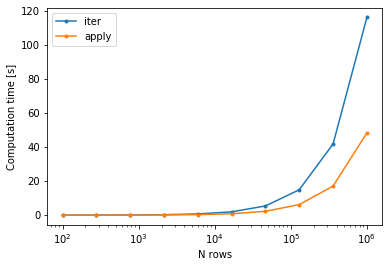

In [14]:
f=plt.figure()
for meth in ['iter','apply']:
    runTimes[meth]=np.array(runTimes[meth])
    plt.semilogx(runTimes['nrows'],runTimes[meth],label=meth,marker='.')
plt.xlabel('N rows')    
plt.ylabel('Computation time [s]')
plt.legend()    
plt.show()

and a speedup factor: 

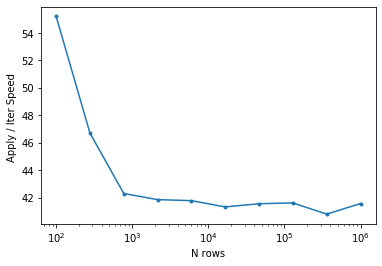

In [15]:
f=plt.figure()
plt.semilogx(runTimes['nrows'],(runTimes['apply'])/runTimes['iter']*100,marker='.')
plt.xlabel('N rows')    
plt.ylabel('Apply / Iter Speed ')
plt.show()


So above about 1000 rows, `apply` + fortran formatting is about 42% faster than a manual loop, so definitely the way to go. 